原始网络的最短路径和: 383.05722914981766


Population=300:   0%|          | 0/60 [00:00<?, ?it/s]

Completed: Pop=300, Select=0.3333333333333333, Mutate=0.05 - Final Fitness=369.80340310499497
Completed: Pop=300, Select=0.3333333333333333, Mutate=0.1 - Final Fitness=362.91627122357886
Completed: Pop=300, Select=0.3333333333333333, Mutate=0.15 - Final Fitness=366.0280907079916
Completed: Pop=300, Select=0.5, Mutate=0.05 - Final Fitness=364.06122958970036
Completed: Pop=300, Select=0.6666666666666666, Mutate=0.05 - Final Fitness=370.36174360789573
Completed: Pop=300, Select=0.5, Mutate=0.1 - Final Fitness=364.0195920478923
Completed: Pop=300, Select=0.5, Mutate=0.15 - Final Fitness=365.50907320568376
Completed: Pop=300, Select=0.6666666666666666, Mutate=0.1 - Final Fitness=365.3898228972157
Completed: Pop=300, Select=0.6666666666666666, Mutate=0.15 - Final Fitness=370.34581174515785
Completed: Pop=300, Select=0.75, Mutate=0.05 - Final Fitness=374.65191343657585
Completed: Pop=300, Select=0.75, Mutate=0.1 - Final Fitness=370.36174360789573
Completed: Pop=300, Select=0.75, Mutate=0.15 -

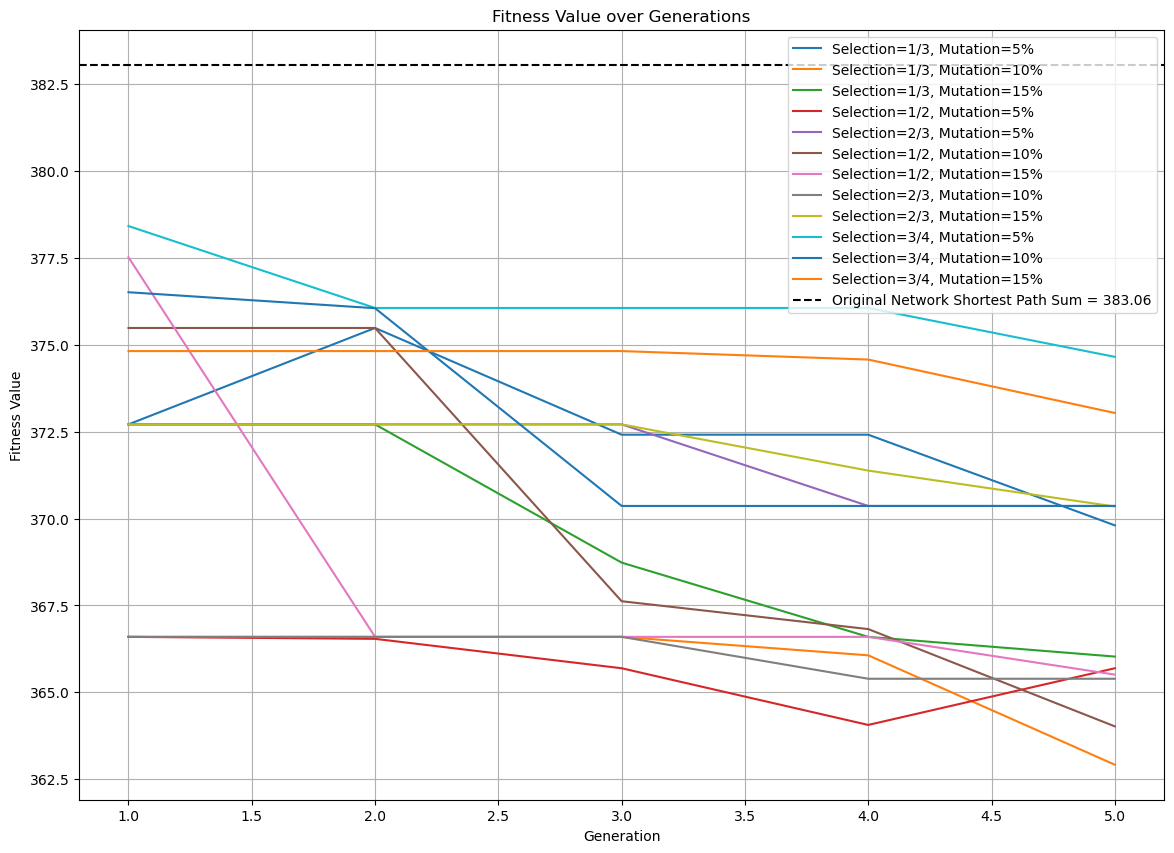

In [1]:
import numpy as np
from graph_tool.all import  shortest_distance
from deap import base, creator, tools, algorithms
import python_codes.files_operators as fo
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed
from fractions import Fraction
from tqdm.notebook import tqdm
import python_codes.newga_utils as ga  # 调整后的导入路径

# 读取图和位置信息
filename1 = "ATT_US_Norm"
read_graph, read_pos = fo.read_files(f"../networks_clusters/{filename1}.net")
num_edges = read_graph.num_edges()

# 计算并添加边的欧氏距离作为权重属性
edge_weights = read_graph.new_edge_property("double")
for edge in read_graph.edges():
    source_pos = read_pos[edge.source()]
    target_pos = read_pos[edge.target()]
    euclidean_distance = np.sqrt((source_pos[0] - target_pos[0]) ** 2 + (source_pos[1] - target_pos[1]) ** 2)
    edge_weights[edge] = euclidean_distance

# 计算原始网络的最短路径和
dist_matrix = shortest_distance(read_graph, weights=edge_weights).get_2d_array(range(read_graph.num_vertices()))
original_network_value = np.sum(dist_matrix[dist_matrix != np.inf])
print(f"原始网络的最短路径和: {original_network_value}")

# 创建个体和适应度
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

# 注册工具箱
toolbox = base.Toolbox()
toolbox.register("individual", ga.init_individual, read_graph=read_graph, edge_weights=edge_weights,
                 num_edges=num_edges)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", ga.evaluate, read_graph=read_graph, read_pos=read_pos, edge_weights=edge_weights)
toolbox.register("mate", ga.cxGraph, num_edges=num_edges)
toolbox.register("mutate", ga.mutGraph, num_edges=num_edges)
toolbox.register("select", tools.selTournament, tournsize=3)


# 主遗传算法流程
def main(population_size, selection_ratio, mutpb, initial_population, pbar, num_generations):
    num_selected = int(population_size * selection_ratio)
    num_offspring = population_size - num_selected
    cxpb = 0.5
    pop = initial_population[:]
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)
    logbook = tools.Logbook()
    logbook.header = ["gen", "min"]

    for gen in range(num_generations):
        selected = toolbox.select(pop, num_selected)
        offspring = algorithms.varAnd(selected, toolbox, cxpb, mutpb)
        offspring = offspring[:num_offspring]
        pop[:] = selected + offspring
        fitnesses = list(map(toolbox.evaluate, pop))
        for ind, fit in zip(pop, fitnesses):
            ind.fitness.values = fit
        record = stats.compile(pop)
        logbook.record(gen=gen, **record)
        pbar.update(1)
        hof.update(pop)

    return logbook, hof[0].fitness.values[0]


# 参数配置
num_generations = 5
population_sizes = [300]
selection_ratios = [1 / 3, 1 / 2, 2 / 3, 3 / 4]
mutation_probs = [0.05, 0.1, 0.15]
progress_bars = {
    pop_size: tqdm(total=12 * num_generations, desc=f'Population={pop_size}', position=i, leave=True)
    for i, pop_size in enumerate(population_sizes)
}

# 执行主流程
initial_population = toolbox.population(n=population_sizes[0])
fitnesses = list(map(toolbox.evaluate, initial_population))
initial_fitness = min(fitnesses)[0]
all_logbooks = []

# 执行每个种群大小的实验并绘图
for population_size in population_sizes:
    initial_population = toolbox.population(n=population_size)
    fitnesses = list(map(toolbox.evaluate, initial_population))
    initial_fitness = min(fitnesses)[0]

    with ThreadPoolExecutor(max_workers=4) as executor:
        future_to_params = {
            executor.submit(main, population_size, selection_ratio, mutpb, initial_population,
                            progress_bars[population_size], num_generations): (
                selection_ratio, mutpb)
            for selection_ratio in selection_ratios
            for mutpb in mutation_probs
        }

        for future in as_completed(future_to_params):
            selection_ratio, mutpb = future_to_params[future]
            try:
                logbook, final_fitness = future.result()
                all_logbooks.append((logbook, selection_ratio, mutpb))

                print(
                    f'Completed: Pop={population_size}, Select={selection_ratio}, Mutate={mutpb} - Final Fitness={final_fitness}')

            except Exception as ex:
                print(f'Error with Pop={population_size}, Select={selection_ratio}, Mutate={mutpb}: {ex}')

# 绘制适应度值随代数的变化图
plt.figure(figsize=(14, 10))
for logbook, selection_ratio, mutpb in all_logbooks:
    min_fitness_values = logbook.select("min")
    generations = list(range(1, len(min_fitness_values) + 1))
    fitness_values = [initial_fitness] + min_fitness_values
    generations = [0] + generations

    plt.plot(generations, fitness_values,
             label=f'Selection={Fraction(selection_ratio).limit_denominator()}, Mutation={int(mutpb * 100)}%')

# 在图表上添加原始网络的最短路径和
plt.axhline(y=original_network_value, color='k', linestyle='--',
            label=f'Original Network Shortest Path Sum = {original_network_value:.2f}')
plt.title("Fitness Value over Generations")
plt.xlabel("Generation")
plt.ylabel("Fitness Value")
plt.legend()
plt.grid(True)
plt.show()


原始网络的最短路径和: 383.05722914981766


Population=300:   0%|          | 0/120 [00:00<?, ?it/s]

Completed: Pop=300, Select=0.3333333333333333, Mutate=0.1 - Final Fitness=358.589933030171
Completed: Pop=300, Select=0.3333333333333333, Mutate=0.05 - Final Fitness=362.2289761849649
Completed: Pop=300, Select=0.3333333333333333, Mutate=0.15 - Final Fitness=358.4466619212674


/home/huanghanjun/anaconda3/envs/graph-tool/lib/python3.12/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Completed: Pop=300, Select=0.5, Mutate=0.05 - Final Fitness=366.2120945824285
Completed: Pop=300, Select=0.5, Mutate=0.15 - Final Fitness=361.4958857126376
Completed: Pop=300, Select=0.5, Mutate=0.1 - Final Fitness=353.49533016263285
Completed: Pop=300, Select=0.6666666666666666, Mutate=0.05 - Final Fitness=365.63585229209247
Completed: Pop=300, Select=0.6666666666666666, Mutate=0.1 - Final Fitness=356.17750542924125
Completed: Pop=300, Select=0.75, Mutate=0.1 - Final Fitness=362.72135190737134
Completed: Pop=300, Select=0.6666666666666666, Mutate=0.15 - Final Fitness=359.4113931443644
Completed: Pop=300, Select=0.75, Mutate=0.05 - Final Fitness=371.66140844444493
Completed: Pop=300, Select=0.75, Mutate=0.15 - Final Fitness=364.2812641632899


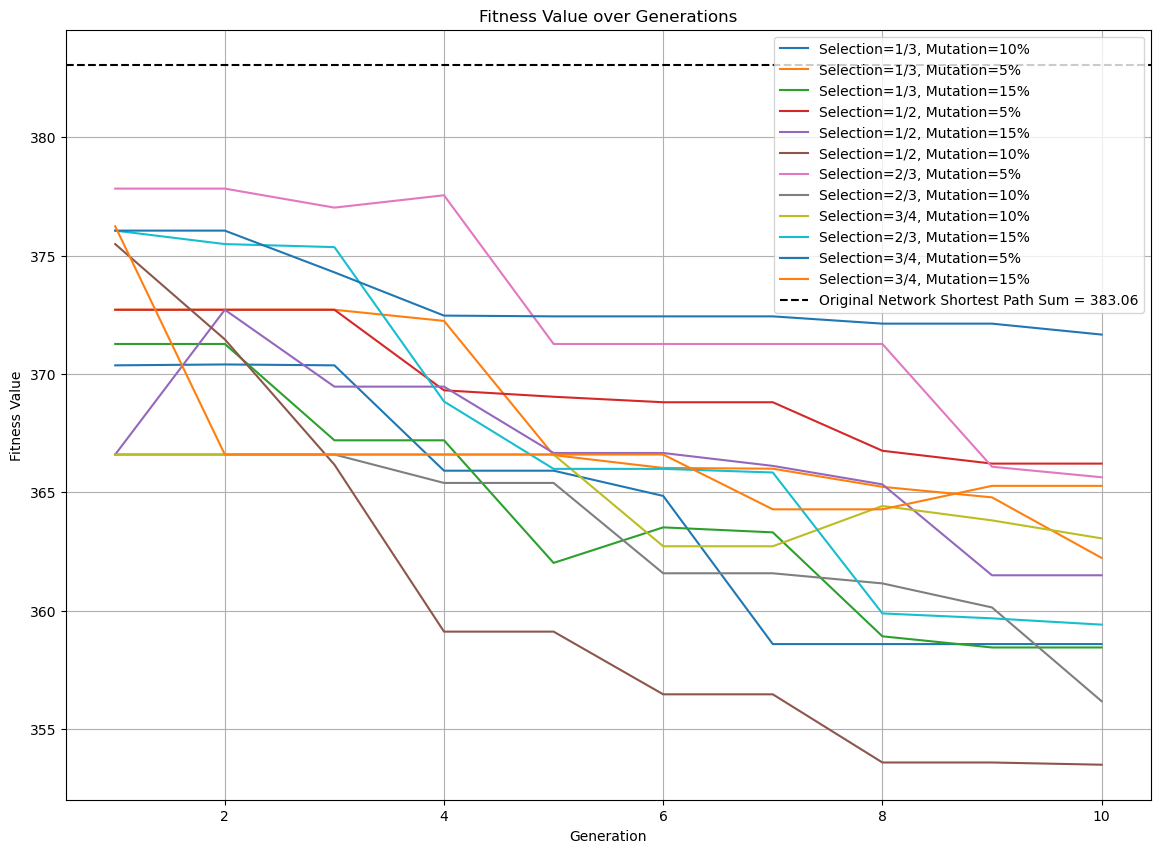

In [1]:
import numpy as np
from graph_tool.all import shortest_distance
from deap import base, creator, tools, algorithms
import python_codes.files_operators as fo
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed
from fractions import Fraction
from tqdm.notebook import tqdm
import python_codes.newga_utils as ga  # 调整后的导入路径

# 读取图和位置信息
filename1 = "ATT_US_Norm"
read_graph, read_pos = fo.read_files(f"../networks_clusters/{filename1}.net")
num_edges = read_graph.num_edges()

# 计算并添加边的欧氏距离作为权重属性
edge_weights = read_graph.new_edge_property("double")
for edge in read_graph.edges():
    source_pos = read_pos[edge.source()]
    target_pos = read_pos[edge.target()]
    euclidean_distance = np.sqrt((source_pos[0] - target_pos[0]) ** 2 + (source_pos[1] - target_pos[1]) ** 2)
    edge_weights[edge] = euclidean_distance

# 计算原始网络的最短路径和
dist_matrix = shortest_distance(read_graph, weights=edge_weights).get_2d_array(range(read_graph.num_vertices()))
original_network_value = np.sum(dist_matrix[dist_matrix != np.inf])
print(f"原始网络的最短路径和: {original_network_value}")

# 创建个体和适应度
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

# 注册工具箱
toolbox = base.Toolbox()
toolbox.register("individual", ga.init_individual, read_graph=read_graph, edge_weights=edge_weights,
                 num_edges=num_edges)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", ga.evaluate, read_graph=read_graph, read_pos=read_pos, edge_weights=edge_weights)
toolbox.register("mate", ga.cxGraph, num_edges=num_edges)
toolbox.register("mutate", ga.mutGraph, num_edges=num_edges)
toolbox.register("select", tools.selTournament, tournsize=3)


# 主遗传算法流程
def main(population_size, selection_ratio, mutpb, initial_population, pbar, num_generations):
    num_selected = int(population_size * selection_ratio)
    num_offspring = population_size - num_selected
    cxpb = 0.5
    pop = initial_population[:]
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)
    logbook = tools.Logbook()
    logbook.header = ["gen", "min"]

    for gen in range(num_generations):
        selected = toolbox.select(pop, num_selected)
        offspring = algorithms.varAnd(selected, toolbox, cxpb, mutpb)
        offspring = offspring[:num_offspring]
        pop[:] = selected + offspring
        fitnesses = list(map(toolbox.evaluate, pop))
        for ind, fit in zip(pop, fitnesses):
            ind.fitness.values = fit
        record = stats.compile(pop)
        logbook.record(gen=gen, **record)
        pbar.update(1)
        hof.update(pop)

    return logbook, hof[0].fitness.values[0]


# 参数配置
num_generations = 10
population_sizes = [300]
selection_ratios = [1 / 3, 1 / 2, 2 / 3, 3 / 4]
mutation_probs = [0.05, 0.1, 0.15]
progress_bars = {
    pop_size: tqdm(total=12 * num_generations, desc=f'Population={pop_size}', position=i, leave=True)
    for i, pop_size in enumerate(population_sizes)
}

# 执行主流程
initial_population = toolbox.population(n=population_sizes[0])
fitnesses = list(map(toolbox.evaluate, initial_population))
initial_fitness = min(fitnesses)[0]
all_logbooks = []

# 执行每个种群大小的实验并绘图
for population_size in population_sizes:
    initial_population = toolbox.population(n=population_size)
    fitnesses = list(map(toolbox.evaluate, initial_population))
    initial_fitness = min(fitnesses)[0]

    with ThreadPoolExecutor(max_workers=4) as executor:
        future_to_params = {
            executor.submit(main, population_size, selection_ratio, mutpb, initial_population,
                            progress_bars[population_size], num_generations): (
                selection_ratio, mutpb)
            for selection_ratio in selection_ratios
            for mutpb in mutation_probs
        }

        for future in as_completed(future_to_params):
            selection_ratio, mutpb = future_to_params[future]
            try:
                logbook, final_fitness = future.result()
                all_logbooks.append((logbook, selection_ratio, mutpb))

                print(
                    f'Completed: Pop={population_size}, Select={selection_ratio}, Mutate={mutpb} - Final Fitness={final_fitness}')

            except Exception as ex:
                print(f'Error with Pop={population_size}, Select={selection_ratio}, Mutate={mutpb}: {ex}')

# 绘制适应度值随代数的变化图
plt.figure(figsize=(14, 10))
for logbook, selection_ratio, mutpb in all_logbooks:
    min_fitness_values = logbook.select("min")
    generations = list(range(1, len(min_fitness_values) + 1))
    fitness_values = [initial_fitness] + min_fitness_values
    generations = [0] + generations

    plt.plot(generations, fitness_values,
             label=f'Selection={Fraction(selection_ratio).limit_denominator()}, Mutation={int(mutpb * 100)}%')

# 在图表上添加原始网络的最短路径和
plt.axhline(y=original_network_value, color='k', linestyle='--',
            label=f'Original Network Shortest Path Sum = {original_network_value:.2f}')
plt.title("Fitness Value over Generations")
plt.xlabel("Generation")
plt.ylabel("Fitness Value")
plt.legend()
plt.grid(True)
plt.show()


In [3]:
# 先导入所需的库
import numpy as np
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed
from fractions import Fraction
from tqdm.notebook import tqdm
import python_codes.newga_utils as ga  # 调整后的导入路径

# 修改主遗传算法流程来记录每一代中最小边长度和的个体
def main(population_size, selection_ratio, mutpb, initial_population, pbar, num_generations):
    num_selected = int(population_size * selection_ratio)
    num_offspring = population_size - num_selected
    cxpb = 0.5
    pop = initial_population[:]
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)
    logbook = tools.Logbook()
    logbook.header = ["gen", "min"]

    # 新增记录边总长度的数组
    edge_length_min_values = []

    for gen in range(num_generations):
        # 选择操作
        selected = toolbox.select(pop, num_selected)
        # 生成新的个体
        offspring = algorithms.varAnd(selected, toolbox, cxpb, mutpb)
        offspring = offspring[:num_offspring]
        # 更新种群
        pop[:] = selected + offspring
        # 评估适应度
        fitnesses = list(map(toolbox.evaluate, pop))
        for ind, fit in zip(pop, fitnesses):
            ind.fitness.values = fit
        # 记录和输出每一代的最优适应度值
        record = stats.compile(pop)
        logbook.record(gen=gen, **record)
        pbar.update(1)
        hof.update(pop)

        # 找到每一代中边的总长度最小的个体
        min_edge_length = float('inf')
        for ind in pop:
            graph, new_edge_weights = ga.individual_to_graph(ind, read_graph.num_vertices(), read_pos)
            total_edge_length = np.sum([new_edge_weights[edge] for edge in graph.edges()])
            if total_edge_length < min_edge_length:
                min_edge_length = total_edge_length
        edge_length_min_values.append(min_edge_length)  # 保存最小边总长度

    return logbook, hof[0].fitness.values[0], edge_length_min_values


# 调整绘图部分
# 执行主流程
initial_population = toolbox.population(n=population_sizes[0])
fitnesses = list(map(toolbox.evaluate, initial_population))
initial_fitness = min(fitnesses)[0]
all_logbooks = []
all_edge_lengths = []

# 执行每个种群大小的实验并绘图
for population_size in population_sizes:
    initial_population = toolbox.population(n=population_size)
    fitnesses = list(map(toolbox.evaluate, initial_population))
    initial_fitness = min(fitnesses)[0]

    with ThreadPoolExecutor(max_workers=4) as executor:
        future_to_params = {
            executor.submit(main, population_size, selection_ratio, mutpb, initial_population,
                            progress_bars[population_size], num_generations): (
                selection_ratio, mutpb)
            for selection_ratio in selection_ratios
            for mutpb in mutation_probs
        }

        for future in as_completed(future_to_params):
            selection_ratio, mutpb = future_to_params[future]
            try:
                logbook, final_fitness, edge_length_min_values = future.result()
                all_logbooks.append((logbook, selection_ratio, mutpb))
                all_edge_lengths.append((edge_length_min_values, selection_ratio, mutpb))

                print(
                    f'Completed: Pop={population_size}, Select={selection_ratio}, Mutate={mutpb} - Final Fitness={final_fitness}')

            except Exception as ex:
                print(f'Error with Pop={population_size}, Select={selection_ratio}, Mutate={mutpb}: {ex}')

# 绘制适应度值随代数的变化图
plt.figure(figsize=(14, 10))
for logbook, selection_ratio, mutpb in all_logbooks:
    min_fitness_values = logbook.select("min")
    generations = list(range(1, len(min_fitness_values) + 1))
    fitness_values = [initial_fitness] + min_fitness_values
    generations = [0] + generations

    plt.plot(generations, fitness_values,
             label=f'Selection={Fraction(selection_ratio).limit_denominator()}, Mutation={int(mutpb * 100)}%')

# 在图表上添加原始网络的最短路径和
plt.axhline(y=original_network_value, color='k', linestyle='--',
            label=f'Original Network Shortest Path Sum = {original_network_value:.2f}')
plt.title("Fitness Value over Generations")
plt.xlabel("Generation")
plt.ylabel("Fitness Value")
plt.legend()
plt.grid(True)
plt.show()

# 新增：绘制每代最小边总长度变化图
plt.figure(figsize=(14, 10))
for edge_length_min_values, selection_ratio, mutpb in all_edge_lengths:
    generations = list(range(num_generations))
    plt.plot(generations, edge_length_min_values,
             label=f'Selection={Fraction(selection_ratio).limit_denominator()}, Mutation={int(mutpb * 100)}%')

plt.title("Minimum Total Edge Length over Generations")
plt.xlabel("Generation")
plt.ylabel("Total Edge Length")
plt.legend()
plt.grid(True)
plt.show()


Completed: Pop=300, Select=0.3333333333333333, Mutate=0.05 - Final Fitness=355.7121280208435
Completed: Pop=300, Select=0.5, Mutate=0.1 - Final Fitness=360.8698117740449
Completed: Pop=300, Select=0.5, Mutate=0.15 - Final Fitness=353.966417343741
Completed: Pop=300, Select=0.6666666666666666, Mutate=0.05 - Final Fitness=359.771000803869
Completed: Pop=300, Select=0.6666666666666666, Mutate=0.1 - Final Fitness=356.0582598304585
Completed: Pop=300, Select=0.6666666666666666, Mutate=0.15 - Final Fitness=357.415571758169
Completed: Pop=300, Select=0.75, Mutate=0.05 - Final Fitness=370.09713767212435
Completed: Pop=300, Select=0.75, Mutate=0.1 - Final Fitness=356.7329576035463
Completed: Pop=300, Select=0.75, Mutate=0.15 - Final Fitness=361.19270064273894


KeyboardInterrupt: 